Steps:
1. Take the full signal and randomly pick N trials
2. Calculate Pearson trial-average
3. Calculate STTC trial-average
4. Calculate STTC on concatenated data
5. Compare 2,3,4, values calculated on full signal, and ground truth

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 

import numpy as np
from random import randrange
# IP import warnings because of "module 'numpy' has no attribute 'warnings'"
import warnings
np.warnings = warnings
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score

# import from scripts
import os
os.chdir(os.path.expanduser("D:\\intr_timescales\\isttc\\scripts"))
from calculate_acf import acf_sttc, sttc_zero_padded, acf_pearsonr_trial_avg, acf_sttc_trial_avg, acf_sttc_trail_concat, acf_sttc_trail_concat_v2, acf_sttc_trail_concat_v3

### Load the data

In [2]:
spike_times = np.load('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split\\spike_times.npy')
ou_spiketrain_binned = np.load('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split\\ou_spiketrain_binned.npy')

In [3]:
num_lags = 20
bin_size = 50
sttc_dt = 49
signal_len = 100000

In [4]:
def func_exp_abc_like(x, a, tau):
    return a * np.exp(-x/tau) 

def func_single_exp_monkey_like(x, a, b, c):
    #return a * np.exp(-b * x) + c
    return a * (np.exp(-b * x) + c) # as in the paper

### Calculate acf and sttc for the full signal

In [5]:
t_axes = np.linspace(0,num_lags,num_lags+1).astype(int)
print(t_axes)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [6]:
# Using acf func
spike_train_binned_acf = acf(ou_spiketrain_binned[0], nlags=num_lags)
print('spike_train_binned_acf shape {}, \nspike_train_binned_acf: {}'.format(spike_train_binned_acf.shape, spike_train_binned_acf))

# Using isttc
spike_train_acf = acf_sttc(spike_times, num_lags, lag_shift_=bin_size, sttc_dt_=sttc_dt, signal_length_=signal_len, verbose_=False)
print('spike_train_acf shape {}, \nspike_train_acf: {}'.format(len(spike_train_acf), spike_train_acf))

# calculate tau
spike_train_binned_popt, _ = curve_fit(func_single_exp_monkey_like, t_axes, spike_train_binned_acf, maxfev=5000)
spike_train_binned_tau_ms = (1/spike_train_binned_popt[1]) * bin_size
print('spike_train_binned_popt: {}, spike_train_binned_tau_ms: {}'.format(spike_train_binned_popt, spike_train_binned_tau_ms))

spike_train_popt, _ = curve_fit(func_single_exp_monkey_like, t_axes, spike_train_acf, maxfev=5000)
spike_train_tau_ms = (1/spike_train_popt[1]) * bin_size
print('spike_train_popt: {}, spike_train_tau_ms: {}'.format(spike_train_popt, spike_train_tau_ms))

spike_train_binned_acf shape (21,), 
spike_train_binned_acf: [ 1.          0.49215131  0.2821505   0.1616106   0.08844024  0.07648782
  0.02344463 -0.00867316 -0.01960204 -0.04462376 -0.03282076 -0.03199797
 -0.04016174 -0.00992729 -0.01154496 -0.00658597  0.01306548  0.04077162
  0.06785523  0.04134784  0.0492438 ]
428750
t_stop_ - t_start_: 100000, time_prop: 0.68591
428750
t_stop_ - t_start_: 100000, time_prop: 0.68591
STTC : 1.0
spike_train_acf shape 21, 
spike_train_acf: [1.0, 0.7706103545583978, 0.4204157053544422, 0.23715788712972305, 0.13207384122926805, 0.07066300033196116, 0.019195003371161166, -0.009948068613723278, -0.01636808389622811, -0.031813959125070665, -0.030645304931782455, -0.04569479773635923, -0.035081240532766525, -0.028599466254498197, -0.02127989014486014, -0.00855320786148805, 0.02685765707447492, 0.054989314885117546, 0.0638279371377392, 0.08527762793619001, 0.0993537544071131]
spike_train_binned_popt: [0.98801718 0.64324775 0.00231552], spike_train_binned_t

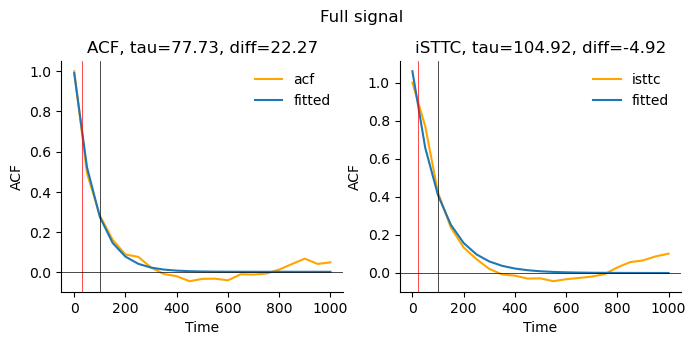

In [7]:
fig, axes = plt.subplots(1,2, figsize=(8,3))

axes[0].plot(t_axes, spike_train_binned_acf, c='orange', label='acf')
axes[0].plot(t_axes, func_single_exp_monkey_like(t_axes, spike_train_binned_popt[0], spike_train_binned_popt[1], spike_train_binned_popt[2]), 
             label='fitted')
axes[0].axvline(x=spike_train_binned_popt[1], lw=0.5, color='red')
axes[0].set_title('ACF, tau={}, diff={}'.format(np.round(spike_train_binned_tau_ms, 2), np.round(100-spike_train_binned_tau_ms, 2)))
axes[0].set_xticks(np.linspace(0,20,6))
axes[0].set_xticklabels(np.linspace(0,1000,6).astype(int))

axes[1].plot(t_axes, spike_train_acf, c='orange', label='isttc')
axes[1].plot(t_axes, func_single_exp_monkey_like(t_axes, spike_train_popt[0], spike_train_popt[1], spike_train_popt[2]), label='fitted')
axes[1].axvline(x=spike_train_popt[1], lw=0.5, color='red')
axes[1].set_title('iSTTC, tau={}, diff={}'.format(np.round(spike_train_tau_ms, 2), np.round(100-spike_train_tau_ms, 2)))
axes[1].set_xticks(np.linspace(0,20,6))
axes[1].set_xticklabels(np.linspace(0,1000,6).astype(int))

fig.suptitle('Full signal', y=1.05)

for ax in axes.flat:
    ax.legend(frameon=False)
    ax.axvline(x=2, lw=0.5, color='k')
    ax.axhline(y=0, lw=0.5, color='k')
    ax.set_xlabel('Time')
    ax.set_ylabel('ACF')

sns.despine()

#fig.savefig('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split\\figs\\' + 'full_signal.png' , bbox_inches='tight')

### Make trials

In [8]:
def get_trials(spike_times_, signal_len_, n_trials_, trial_len_, verbose_=False):
    # get random trail starts and ends
    trials_start = [randrange(0, signal_len_-trial_len_+1) for i in range(n_trials_)]
    trials_end = [trial_start + trial_len_ for trial_start in trials_start]
    trial_intervals = np.vstack((trials_start, trials_end)).T
    if verbose_:
        print('N trials {}, trail len {}, n trial starts {}, \ntrial starts {}, \ntrial starts {}'.format(n_trials_, trial_len_, 
                                                                                                          len(trials_start), 
                                                                                                          trials_start, trials_end))
    # get spikes
    spikes_trials = []
    for i in range(n_trials_):
        spikes_trial = spike_times_[np.logical_and(spike_times_ >= trial_intervals[i,0], spike_times_ < trial_intervals[i,1])]
        spikes_trials.append(spikes_trial)

    # realign all trails to start with 0
    spikes_trials_realigned_l = []
    for idx, trial in enumerate(spikes_trials):
        spikes_trial_realigned = trial - trial_intervals[idx,0] 
        spikes_trials_realigned_l.append(spikes_trial_realigned)

    return spikes_trials_realigned_l

def bin_trials(spikes_trials_l_, trial_len_, bin_size_):
    binned_spikes_trials_l = []

    n_bin_edges =  int(trial_len_/bin_size_)
    bins_ = np.linspace(0, bin_size * n_bin_edges, n_bin_edges + 1).astype(int)
    for trial in spikes_trials_l_:
        binned_spike_train, _ = np.histogram(trial, bins_)
        binned_spikes_trials_l.append(binned_spike_train)
    binned_spikes_trials_2d = np.asarray(binned_spikes_trials_l)

    return binned_spikes_trials_2d

### Run for one trial realization

In [9]:
# n_trials = 30
# trial_len = num_lags * bin_size

# spikes_trials_30 = get_trials(spike_times, signal_len, n_trials, trial_len, verbose_=False)
# spikes_trials_30_binned = bin_trials(spikes_trials_30, trial_len, bin_size)

In [10]:
# # Pearson trial-average
# acf_matrix_trail_avg, acf_average_trial_avg = acf_pearsonr_trial_avg(spikes_trials_30_binned, n_lags_=num_lags)
# spike_train_trial_avg_popt, _ = curve_fit(func_single_exp_monkey_like, np.linspace(0,19,20), acf_average_trial_avg, maxfev=5000)
# spike_train_trial_avg_tau_ms = (1/spike_train_trial_avg_popt[1]) * bin_size
# print(spike_train_trial_avg_tau_ms)

# # STTC trial-average
# sttc_matrix_trail_avg, sttc_average_trial_avg = acf_sttc_trial_avg(spikes_trials_30, 
#                                                                    lag_shift_=bin_size, 
#                                                                    zero_padding_len_=120, 
#                                                                    fs_=1000, 
#                                                                    sttc_dt_=sttc_dt, 
#                                                                    verbose_=False)
# spike_train_trial_avg_sttc_popt, _ = curve_fit(func_single_exp_monkey_like, np.linspace(0,19,20), sttc_average_trial_avg, maxfev=5000)
# spike_train_trial_avg_sttc_tau_ms = (1/spike_train_trial_avg_sttc_popt[1]) * bin_size
# print(spike_train_trial_avg_sttc_tau_ms)

# # STTC concat
# acf_sttc_trial_concat_v2 = acf_sttc_trail_concat_v2(spikes_trials_30, 
#                                                                       n_lags_ = num_lags,
#                                                                       lag_shift_=bin_size, 
#                                                                       sttc_dt_=sttc_dt, 
#                                                                       trial_len_=trial_len, 
#                                                                       zero_padding_len_=2000,
#                                                                       verbose_=False)
# spike_train_trial_concat_sttc_v2_popt, _ = curve_fit(func_single_exp_monkey_like, np.linspace(0,num_lags,num_lags+1), acf_sttc_trial_concat_v2, maxfev=5000)
# spike_train_trial_concat_sttc_v2_tau_ms = (1/spike_train_trial_concat_sttc_v2_popt[1]) * bin_size
# print(spike_train_trial_concat_sttc_v2_tau_ms)

In [20]:
### Run for 100 realizations
n_stims = 500

n_trials = 20
trial_len = num_lags * bin_size

pearson_avg_l = []
sttc_avg_l = []
sttc_concat_l = []
sttc_concat_v3_l = []
stim_l = []

for i in range(n_stims):
    spikes_trials_stim = get_trials(spike_times, signal_len, n_trials, trial_len, verbose_=False)
    spikes_trials_binned_stim = bin_trials(spikes_trials_stim, trial_len, bin_size)

    # Pearson trial-average
    acf_matrix_trail_avg, acf_average_trial_avg = acf_pearsonr_trial_avg(spikes_trials_binned_stim, n_lags_=num_lags, verbose_=False)
    spike_train_trial_avg_popt, _ = curve_fit(func_single_exp_monkey_like, np.linspace(0,19,20), acf_average_trial_avg, maxfev=5000)
    spike_train_trial_avg_tau_ms = (1/spike_train_trial_avg_popt[1]) * bin_size
    #print(spike_train_trial_avg_tau_ms)
    
    # STTC trial-average
    sttc_matrix_trail_avg, sttc_average_trial_avg = acf_sttc_trial_avg(spikes_trials_stim, 
                                                                       lag_shift_=bin_size, 
                                                                       zero_padding_len_=120, 
                                                                       fs_=1000, 
                                                                       sttc_dt_=sttc_dt, 
                                                                       verbose_=False)
    spike_train_trial_avg_sttc_popt, _ = curve_fit(func_single_exp_monkey_like, np.linspace(0,19,20), sttc_average_trial_avg, maxfev=5000)
    spike_train_trial_avg_sttc_tau_ms = (1/spike_train_trial_avg_sttc_popt[1]) * bin_size
    #print(spike_train_trial_avg_sttc_tau_ms)
    
    # STTC concat
    acf_sttc_trial_concat_v2 = acf_sttc_trail_concat_v2(spikes_trials_stim, 
                                                                          n_lags_ = num_lags,
                                                                          lag_shift_=bin_size, 
                                                                          sttc_dt_=sttc_dt, 
                                                                          trial_len_=trial_len, 
                                                                          zero_padding_len_=2000,
                                                                          verbose_=False)
    spike_train_trial_concat_sttc_v2_popt, _ = curve_fit(func_single_exp_monkey_like, np.linspace(0,num_lags-1,num_lags), acf_sttc_trial_concat_v2, maxfev=5000)
    spike_train_trial_concat_sttc_v2_tau_ms = (1/spike_train_trial_concat_sttc_v2_popt[1]) * bin_size
    #print(spike_train_trial_concat_sttc_v2_tau_ms)

    # STTC concat v3
    acf_sttc_trial_concat_v3 = acf_sttc_trail_concat_v3(spikes_trials_stim, 
                                                                          n_lags_ = num_lags,
                                                                          lag_shift_=bin_size, 
                                                                          sttc_dt_=sttc_dt, 
                                                                          trial_len_=trial_len, 
                                                                          zero_padding_len_=2000,
                                                                          verbose_=False)
    spike_train_trial_concat_sttc_v3_popt, _ = curve_fit(func_single_exp_monkey_like, np.linspace(0,num_lags-1,num_lags), acf_sttc_trial_concat_v3, maxfev=5000)
    spike_train_trial_concat_sttc_v3_tau_ms = (1/spike_train_trial_concat_sttc_v3_popt[1]) * bin_size
    #print(spike_train_trial_concat_sttc_v2_tau_ms)

    stim_l.append(i)
    pearson_avg_l.append(spike_train_trial_avg_tau_ms)
    sttc_avg_l.append(spike_train_trial_avg_sttc_tau_ms)
    sttc_concat_l.append(spike_train_trial_concat_sttc_v2_tau_ms)
    sttc_concat_v3_l.append(spike_train_trial_concat_sttc_v3_tau_ms)

In [21]:
tau_df = pd.DataFrame(np.vstack((stim_l, pearson_avg_l, sttc_avg_l, sttc_concat_l, sttc_concat_v3_l)).T, 
                      columns=['run_id', 'tau_pearsonr_avg', 'tau_sttc_avg', 'tau_sttc_concat', 'tau_sttc_concat_v3'])
tau_df_long = pd.melt(tau_df, id_vars=['run_id'], value_vars=['tau_pearsonr_avg', 'tau_sttc_avg', 'tau_sttc_concat', 'tau_sttc_concat_v3'], 
                      value_name='tau_ms', var_name='method')

In [22]:
tau_df.describe()

,run_id,tau_pearsonr_avg,tau_sttc_avg,tau_sttc_concat,tau_sttc_concat_v3
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,249.500000,85.599804,92.013754,119.264463,107.736755
std,144.481833,32.712626,31.340553,46.550780,30.810052
min,0.000000,40.196670,42.031680,51.565222,49.539795
25%,124.750000,63.866352,70.028094,89.722758,87.075142
50%,249.500000,78.083496,86.446778,107.478461,102.078357
75%,374.250000,98.505632,105.476375,137.215280,120.575013
max,499.000000,373.079736,289.557558,418.813829,287.199743


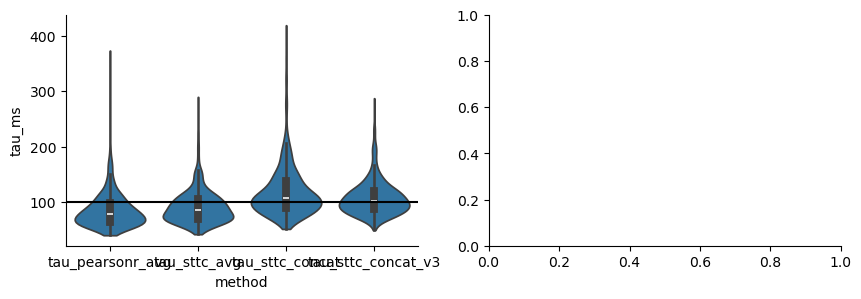

In [23]:
fig, axes = plt.subplots(1,2, figsize=(10,3))

sns.violinplot(ax=axes[0], x='method', y='tau_ms', data=tau_df_long, cut=0,  density_norm='width')
axes[0].axhline(y=100, color='k')

sns.despine()

### ZZZZ

### Calculate Pearson trial-average and STTC trial-average

In [ ]:
# acf_matrix_trail_avg, acf_average_trial_avg = acf_pearsonr_trial_avg(spikes_trials_30_binned, n_lags_=num_lags)
# spike_train_trial_avg_popt, _ = curve_fit(func_single_exp_monkey_like, np.linspace(0,19,20), acf_average_trial_avg, maxfev=5000)
# spike_train_trial_avg_tau_ms = (1/spike_train_trial_avg_popt[1]) * bin_size
# print(spike_train_trial_avg_tau_ms)

In [ ]:
# sns.heatmap(acf_matrix_trail_avg)

In [ ]:
# #acf_sttc_trial_avg(spike_train_l_, lag_shift_=50, zero_padding_len_=150, fs_=1000, sttc_dt_=25, verbose_=True)

# sttc_matrix_trail_avg, sttc_average_trial_avg = acf_sttc_trial_avg(spikes_trials_30, 
#                                                                    lag_shift_=bin_size, 
#                                                                    zero_padding_len_=120, 
#                                                                    fs_=1000, 
#                                                                    sttc_dt_=sttc_dt, 
#                                                                    verbose_=False)
# spike_train_trial_avg_sttc_popt, _ = curve_fit(func_single_exp_monkey_like, np.linspace(0,19,20), sttc_average_trial_avg, maxfev=5000)
# spike_train_trial_avg_sttc_tau_ms = (1/spike_train_trial_avg_sttc_popt[1]) * bin_size
# print(spike_train_trial_avg_sttc_tau_ms)

In [ ]:
#sns.heatmap(sttc_matrix_trail_avg)

### Calculate iSTTC on concatenated trials 

In [ ]:
# version with global T independant from the 0-padding, signal is concatenated, 0-padded, shifted as a whole
# acf_sttc_trial_concat = acf_sttc_trail_concat(spikes_trials_realigned_l, 
#                                                                       n_lags_ = num_lags,
#                                                                       lag_shift_=bin_size, 
#                                                                       sttc_dt_=sttc_dt, 
#                                                                       trial_len_=trial_len, 
#                                                                       zero_padding_len_=2000,
#                                                                       verbose_=False)
# spike_train_trial_concat_sttc_popt, _ = curve_fit(func_single_exp_monkey_like, np.linspace(0,num_lags,num_lags+1), acf_sttc_trial_concat, maxfev=5000)
# spike_train_trial_concat_sttc_tau_ms = (1/spike_train_trial_concat_sttc_popt[1]) * bin_size
# print(spike_train_trial_concat_sttc_tau_ms)

In [ ]:
# acf_sttc_trial_concat_v2 = acf_sttc_trail_concat_v2(spikes_trials_realigned_l, 
#                                                                       n_lags_ = num_lags,
#                                                                       lag_shift_=bin_size, 
#                                                                       sttc_dt_=sttc_dt, 
#                                                                       trial_len_=trial_len, 
#                                                                       zero_padding_len_=2000,
#                                                                       verbose_=False)
# spike_train_trial_concat_sttc_v2_popt, _ = curve_fit(func_single_exp_monkey_like, np.linspace(0,num_lags,num_lags+1), acf_sttc_trial_concat_v2, maxfev=5000)
# spike_train_trial_concat_sttc_v2_tau_ms = (1/spike_train_trial_concat_sttc_v2_popt[1]) * bin_size
# print(spike_train_trial_concat_sttc_v2_tau_ms)